<a href="https://colab.research.google.com/github/NajlaaNawaii/Multilingual-Stable-Diffusion-Towards-more-Inclusive-Text-To-Image-Synthesis/blob/main/Multilingual_Stable_Diffusion_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers==0.2.4 transformers scipy ftfy  "ipywidgets>=7,<8" git+https://github.com/openai/CLIP.git  open_clip_torch transformers diffusers==0.2.4 -q


  Preparing metadata (setup.py) ... done


In [ ]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
#from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

<h4> Normal Batchnorm

In [ ]:
from multilingual_clip import Config_MCLIP
import transformers
import torch


class MultilingualCLIP(transformers.PreTrainedModel):
    config_class = Config_MCLIP.MCLIPConfig

    def __init__(self, config, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.transformer = transformers.AutoModel.from_pretrained(config.modelBase)
        self.LinearTransformation = torch.nn.Linear(in_features=config.transformerDimensions,
                                                    out_features=config.numDims)

    def forward(self, txt, tokenizer, device):
        txt_tok = tokenizer(txt, padding='max_length', max_length=77, truncation=True, return_tensors='pt').to(device)
        embs = self.transformer(**txt_tok)
        print(embs.keys())
        embs = embs[0]
        att = txt_tok['attention_mask']
        embs = (embs * att.unsqueeze(2)) / att.sum(dim=1)[:, None].unsqueeze(2)
        return self.LinearTransformation(embs)

    @classmethod
    def _load_state_dict_into_model(cls, model, state_dict, pretrained_model_name_or_path, _fast_init=True):
        model.load_state_dict(state_dict)
        return model, [], [], []


In [ ]:
import torch
import torch.nn as nn

# Define the adaptation layer, 'checkpoint_9.pth'
class AdaptationLayer(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(AdaptationLayer, self).__init__()
    self.fc1 = nn.Linear(input_dim, output_dim*2)
    torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
    self.bn1 = nn.BatchNorm1d(77)

    self.fc2 = nn.Linear(input_dim*2, output_dim*2)
    torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
    self.bn2 = nn.BatchNorm1d(77)

    self.fc3 = nn.Linear(input_dim*2, output_dim)
    torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
    self.bn3 = nn.BatchNorm1d(77)

    self.fc4 = nn.Linear(input_dim, output_dim)
    torch.nn.init.kaiming_uniform_(self.fc4.weight, nonlinearity='relu')
    self.bn4 = nn.BatchNorm1d(77)

    self.fc5 = nn.Linear(input_dim, output_dim)

  def forward(self, x):
    x = nn.functional.normalize(x, p=2.0, dim=1, eps=1e-12, out=None)
    x = torch.relu(self.bn1(self.fc1(x)))
    x = torch.relu(self.bn2(self.fc2(x)))
    x = torch.relu(self.bn3(self.fc3(x)))
    x = torch.relu(self.bn4(self.fc4(x)))

    return self.fc5(x)

In [ ]:
adapt_model  = AdaptationLayer(768,768)
adapt_model.to(device)
state_dict = torch.load('/content/checkpoint_9.pth')
adapt_model.load_state_dict(state_dict)

FileNotFoundError: ignored

In [ ]:
from multilingual_clip import pt_multilingual_clip
import transformers
from transformers import CLIPTextModel, CLIPTokenizer

texts = [
    'قطة تقرأ كتابا'
]

model_name = 'M-CLIP/LABSE-Vit-L-14'

# Load Model & Tokenizer
text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
text_model = text_model.to(device)
text_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

embeddings= text_model.forward(texts, text_tokenizer, device )
print("Text features shape:", embeddings.shape)

odict_keys(['last_hidden_state', 'pooler_output'])
Text features shape: torch.Size([1, 77, 768])


In [ ]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = text_tokenizer
text_encoder = text_model

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

In [ ]:
def get_text_embeds(prompt):
  with torch.no_grad():
    text_embeddings = text_model(prompt, text_tokenizer, device)
    text_embeddings = adapt_model(text_embeddings)
    print(text_embeddings.shape[1])

  # Do the same for unconditional embeddings
  with torch.no_grad():
    uncond_embeddings = text_model([''] * len(prompt), text_tokenizer, device)
    uncond_embeddings = adapt_model(uncond_embeddings)
    print(uncond_embeddings.shape)

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings


In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings.to(device))['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']

  return latents



In [ ]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents)

  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images


odict_keys(['last_hidden_state', 'pooler_output'])
77
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([1, 77, 768])


0it [00:00, ?it/s]

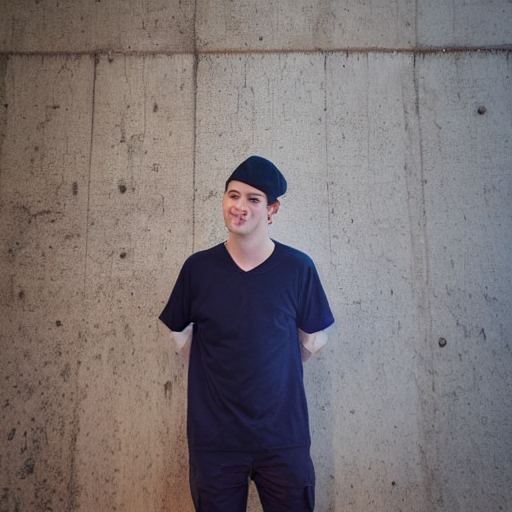

In [ ]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)

  # Img latents -> imgs
  imgs = decode_img_latents(latents)

  return imgs

prompt_to_img('رجل يرتدي قبعة',
              512, 512, 20)[0]